# Python TinyMPC on Quadrotor
In this demonstration, we walk through setting up and leveraging the TinyMPC algorithm in pure Python.

First load necessary packages.

In [ ]:
import math
%matplotlib inline
import matplotlib.pyplot as plt
import autograd.numpy as np
import autograd.numpy as sqrt
from autograd.numpy.linalg import norm
from autograd.numpy.linalg import inv
from autograd import jacobian
from autograd.test_util import check_grads
np.set_printoptions(precision=4, suppress=True)
# Note: autograd does not work with np.block

## Quadrotor Dynamics
Build the quadrotor nonlinear dynamics and linearize around the hovering state using `autograd`.

In [ ]:
#Quaternion stuff, check `Planning with Attitude` paper for more details
def hat(v):
    return np.array([[0, -v[2], v[1]],
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0.0]])

def L(q):
    s = q[0]
    v = q[1:4]
    up = np.hstack([s, -v])
    down = np.hstack([v.reshape(3,1), s*np.eye(3) + hat(v)])
    L = np.vstack([up,down])
    return L

T = np.diag([1.0, -1, -1, -1])
H = np.vstack([np.zeros((1,3)), np.eye(3)])

def qtoQ(q):
    return H.T @ T @ L(q) @ T @ L(q) @ H

def G(q):
    return L(q) @ H

def rptoq(phi):
    return (1./math.sqrt(1+phi.T @ phi)) * np.hstack([1, phi])

def qtorp(q):
    return q[1:4]/q[0]

def E(q):
    up = np.hstack([np.eye(3), np.zeros((3,3)), np.zeros((3,6))])
    mid = np.hstack([np.zeros((4,3)), G(q), np.zeros((4,6))])
    down = np.hstack([np.zeros((6,3)), np.zeros((6,3)), np.eye(6)])
    E = np.vstack([up, mid, down])
    return E

# Quadrotor parameters
mass = 0.035  # mass
J = np.array([[1.66e-5, 0.83e-6, 0.72e-6], [0.83e-6, 1.66e-5, 1.8e-6], [0.72e-6, 1.8e-6, 2.93e-5]])  # inertia
g = 9.81  # gravity
# thrustToTorque = 0.005964552
thrustToTorque = 0.0008  # thrust to torque ratio
el = 0.046/1.414213562  # arm length
scale = 65535  # PWM scale
kt = 2.245365e-6*scale # thrust coefficient, u is PWM in range [0...1], 0 is no thrust, 1 is max thrust
km = kt*thrustToTorque # moment coefficient

freq = 50.0 # >>>>>>>> CONTROL FREQUENCY <<<<<<<<<<
h = 1/freq #50 Hz

Nx1 = 13        # number of states (quaternion)
Nx = 12         # number of states (linearized): x, y, z, Rodriguez 3-parameters (p, q, r), vx, vy, vz, wx, wy, wz
Nu = 4          # number of controls (motor pwm signals, 0-1)

# Quadrotor dynamics -- single rigid body dynamics
def quad_dynamics(x, u):
    r = x[0:3]  # position
    q = x[3:7]/norm(x[3:7])  # normalize quaternion
    v = x[7:10]  # linear velocity
    omg = x[10:13]  # angular velocity
    Q = qtoQ(q)  # quaternion to rotation matrix

    dr = v
    dq = 0.5*L(q)@H@omg
    dv = np.array([0, 0, -g]) + (1/mass)*Q@np.array([[0, 0, 0, 0], [0, 0, 0, 0], [kt, kt, kt, kt]])@u
    domg = inv(J)@(-hat(omg)@J@omg + np.array([[-el*kt, -el*kt, el*kt, el*kt], [-el*kt, el*kt, el*kt, -el*kt], [-km, km, -km, km]])@u)

    return np.hstack([dr, dq, dv, domg])

# RK4 integration with zero-order hold on u
def quad_dynamics_rk4(x, u):
    f1 = quad_dynamics(x, u)
    f2 = quad_dynamics(x + 0.5*h*f1, u)
    f3 = quad_dynamics(x + 0.5*h*f2, u)
    f4 = quad_dynamics(x + h*f3, u)
    xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
    xnormalized = xn[3:7]/norm(xn[3:7])  # normalize quaternion
    return np.hstack([xn[0:3], xnormalized, xn[7:13]])

# Linearize the dynamics around xg, uhover
A_jac = jacobian(quad_dynamics_rk4, 0)  # jacobian wrt x
B_jac = jacobian(quad_dynamics_rk4, 1)  # jacobian wrt u

## Test Nominal Controller to Hover

In [ ]:
# Hovering state and control input
rg = np.array([0.0, 0, 0.0])
qg = np.array([1.0, 0, 0, 0])
vg = np.zeros(3)
omgg = np.zeros(3)
xg = np.hstack([rg, qg, vg, omgg])
uhover = (mass*g/kt/4)*np.ones(4)  # ~each motor thrust to compensate for gravity
print("Hovering Initial State and Control")
print(xg, uhover)

check_grads(quad_dynamics_rk4, modes=['rev'], order=2)(xg, uhover)

Anp1 = A_jac(xg, uhover)  # jacobian of the dynamics wrt x at xg, uhover
Bnp1 = B_jac(xg, uhover)  # jacobian of the dynamics wrt u at xg, uhover

# `Planning with Attitude` trick, attitude Jacobians
#  https://rexlab.ri.cmu.edu/papers/planning_with_attitude.pdf
Anp = E(qg).T @ Anp1 @ E(qg)
Bnp = E(qg).T @ Bnp1
# print("A = \n", Anp)
# print("B = \n", Bnp)

# x0[0:3] += rg + 3*np.random.randn(3)/3  # disturbed initial position
x0 = np.copy(xg)
x0[0:3] += rg + np.array([0.2, 0.2, -0.2])  # disturbed initial position
x0[3:7] = rptoq(np.array([1.0, 0.0, 0.0]))  # disturbed initial attitude
print("Perturbed Intitial State")
print(x0)

Hovering Initial State and Control
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0.5833 0.5833 0.5833 0.5833]
Perturbed Intitial State
[ 0.2     0.2    -0.2     0.7071  0.7071  0.      0.      0.      0.
  0.      0.      0.      0.    ]


In [ ]:
# function to visualize the trajectory
def visualize_trajectory(x_all, u_all):
    # Set up the figure and axis for plotting
    fig, ax = plt.subplots(3, 1)

    # Plot the trajectory
    x_all = np.array(x_all)
    nsteps = len(x_all)
    steps = np.arange(nsteps)
    ax[0].plot(steps, x_all[:, 0], label="x", linewidth=2)
    ax[0].plot(steps, x_all[:, 1], label="y", linewidth=2)
    ax[0].plot(steps, x_all[:, 2], label="z", linewidth=2)
    ax[0].legend()
    ax[0].title.set_text("Position")

    ax[1].plot(steps, x_all[:, 3], label="q0", linewidth=2)
    ax[1].plot(steps, x_all[:, 4], label="q1", linewidth=2)
    ax[1].plot(steps, x_all[:, 5], label="q2", linewidth=2)
    ax[1].plot(steps, x_all[:, 6], label="q3", linewidth=2)
    ax[1].legend()
    ax[1].title.set_text("Attitude")

    u_all = np.array(u_all)
    nsteps = len(u_all)
    steps = np.arange(nsteps)
    ax[2].plot(steps, u_all[:, 0], label="u1", linewidth=2)
    ax[2].plot(steps, u_all[:, 1], label="u2", linewidth=2)
    ax[2].plot(steps, u_all[:, 2], label="u3", linewidth=2)
    ax[2].plot(steps, u_all[:, 3], label="u4", linewidth=2)
    # ax[2].legend()
    ax[2].title.set_text("Controls")
    plt.show()


# function to simulate with a controller
def simulate_with_controller(x0, x_nom, u_nom, controller, NSIM = 100):
    x_all = []
    u_all = []
    x_curr = np.copy(x0)
    # simulate the dynamics with the LQR controller
    for i in range(NSIM):
        u_curr = controller(x_curr, x_nom, u_nom)
        u_curr_clipped = np.clip(u_curr, 0, 1)
        x_curr = quad_dynamics_rk4(x_curr, u_curr_clipped)
        x_curr = x_curr.reshape(x_curr.shape[0]).tolist()
        u_curr = u_curr.reshape(u_curr.shape[0]).tolist()
        x_all.append(x_curr)
        u_all.append(u_curr)
    return x_all, u_all

## Test LQR Controller to Hover

K LQR = 
 [[-0.217   0.211   0.4003 -0.6191 -0.6866 -0.7735 -0.1287  0.122   0.2324
  -0.0445 -0.0555 -0.2939]
 [ 0.2083  0.1901  0.4003 -0.4929  0.6557  0.7848  0.1231  0.1058  0.2324
  -0.0274  0.0532  0.2961]
 [ 0.1873 -0.1992  0.4003  0.5245  0.4498 -0.8112  0.1024 -0.1115  0.2324
   0.0297  0.0185 -0.3013]
 [-0.1786 -0.202   0.4003  0.5875 -0.4189  0.8    -0.0968 -0.1163  0.2324
   0.0422 -0.0162  0.2991]]


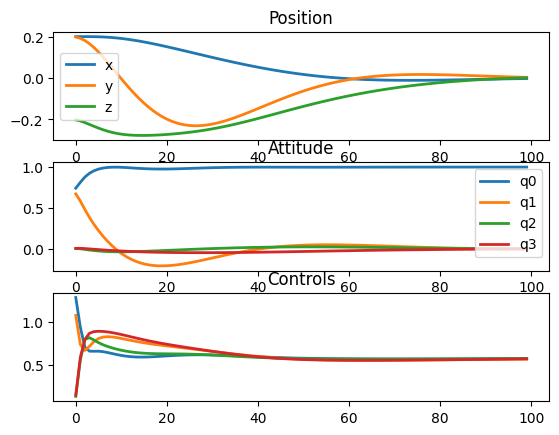

In [ ]:
# Choose Q and R matrices based on Bryson's rule
max_dev_x = np.array([0.1, 0.1, 0.1,  0.5, 0.5, 0.05,  0.5, 0.5, 0.5,  0.7, 0.7, 0.2])
max_dev_u = np.array([0.5, 0.5, 0.5, 0.5])/6
Q = np.diag(1./max_dev_x**2)
R = np.diag(1./max_dev_u**2)

# Riccati recursion on the linearized dynamics
def dlqr(A, B, Q, R, n_steps = 500):
    P = Q
    for i in range(n_steps):
        K = inv(R + B.T @ P @ B) @ B.T @ P @ A
        P = Q + A.T @ P @ (A - B @ K)
    return K, P

K_lqr, P_lqr = dlqr(Anp, Bnp, Q, R)
print("K LQR = \n", K_lqr)

# Drive the system from initial state to the hovering state using the LQR controller:
# LQR controller, input is 13x1 state vector
def delta_x_quat(x_curr):
    q = x_curr[3:7]
    phi = qtorp(L(qg).T @ q)
    delta_x = np.hstack([x_curr[0:3]-rg, phi, x_curr[7:10]-vg, x_curr[10:13]-omgg])
    return delta_x
def lqr_controller(x_curr, x_nom, u_nom):
    delta_x = delta_x_quat(x_curr)
    return u_nom - K_lqr @ delta_x

x_lqr, u_lqr = simulate_with_controller(x0, xg, uhover, lqr_controller)
visualize_trajectory(x_lqr, u_lqr)

## Define TinyMPC in Python

We are done with the dynamics and LQR controller. Now, let's define the class and create a TinyMPC class.

In [ ]:
class TinyMPC:
    def __init__(self, input_data, Nsteps, mode = 0):
        if (mode == 0):
            self.cache = {}
            self.cache['rho'] = input_data['rho']
            self.cache['A'] = input_data['A']
            self.cache['B'] = input_data['B']
            self.cache['Q'] = input_data['Q']
            self.cache['R'] = input_data['R']
            self.compute_cache_terms()
        else:
            self.cache = input_data
        self.set_tols_iters()
        self.x_prev = np.zeros((self.cache['A'].shape[0],Nsteps))
        self.u_prev = np.zeros((self.cache['B'].shape[1],Nsteps))
        self.N = Nsteps

    def compute_cache_terms(self, max_iters=5000, tol=1e-10, verbose=True):
        # Add rho to R and Q
        Q_rho = self.cache['Q']
        R_rho = self.cache['R']
        R_rho += self.cache['rho'] * np.eye(R_rho.shape[0])
        Q_rho += self.cache['rho'] * np.eye(Q_rho.shape[0])

        # Initialize Kinf and Pinf
        A = self.cache['A']
        B = self.cache['B']
        Kinf = np.zeros(B.T.shape)
        Pinf = np.copy(Q)
        Kinf_prev = np.copy(Kinf)

        # Iterative computation
        for k in range(max_iters):
            Kinf = inv(R_rho + B.T @ Pinf @ B) @ B.T @ Pinf @ A
            Pinf = Q_rho + A.T @ Pinf @ (A - B @ Kinf)

            # Check convergence
            if np.linalg.norm(Kinf - Kinf_prev, 2) < tol:
                if verbose:
                    print(f"ihlqr converged in {k} iterations")
                break

            # Update Kinf_prev
            Kinf_prev = np.copy(Kinf)

        # Precompute useful matrices
        AmBKt = (A - B @ Kinf).T
        Quu_inv = np.linalg.inv(R_rho + B.T @ Pinf @ B)

        # Save to cache
        self.cache['Kinf'] = Kinf
        self.cache['Pinf'] = Pinf
        self.cache['C1'] = Quu_inv
        self.cache['C2'] = AmBKt

    def backward_pass_grad(self, d, p, q, r):
        for k in range(self.N-2, -1, -1):
            d[:, k] = np.dot(self.cache['C1'], np.dot(self.cache['B'].T, p[:, k + 1]) + r[:, k])
            p[:, k] = q[:, k] + np.dot(self.cache['C2'], p[:, k + 1]) - np.dot(self.cache['Kinf'].T, r[:, k])

    def forward_pass(self, x, u, d):
        for k in range(self.N - 1):
            u[:, k] = -np.dot(self.cache['Kinf'], x[:, k]) - d[:, k]
            x[:, k + 1] = np.dot(self.cache['A'], x[:, k]) + np.dot(self.cache['B'], u[:, k])

    def update_primal(self, x, u, d, p, q, r):
        self.backward_pass_grad(d, p, q, r)
        self.forward_pass(x, u, d)

    def update_slack(self, z, v, y, g, u, x, umax = None, umin = None, xmax = None, xmin = None):
        for k in range(self.N - 1):
            z[:, k] = u[:, k] + y[:, k]
            v[:, k] = x[:, k] + g[:, k]

            if (umin is not None) and (umax is not None):
                z[:, k] = np.clip(z[:, k], umin, umax)

            if (xmin is not None) and (xmax is not None):
                v[:, k] = np.clip(v[:, k], xmin, xmax)

        # Update for the last time step
        v[:, self.N-1] = x[:, self.N-1] + g[:, self.N-1]
        if (xmin is not None) and (xmax is not None):
            v[:, self.N-1] = np.clip(v[:, self.N-1], xmin, xmax)

    def update_dual(self, y, g, u, x, z, v):
        for k in range(self.N - 1):
            y[:, k] += u[:, k] - z[:, k]
            g[:, k] += x[:, k] - v[:, k]
        g[:, self.N-1] += x[:, self.N-1] - v[:, self.N-1]

    def update_linear_cost(self, r, q, p, z, v, y, g, u_ref, x_ref):
        for k in range(self.N - 1):
            r[:, k] = -self.cache['R'] @ u_ref[:, k]
            r[:, k] -= self.cache['rho'] * (z[:, k] - y[:, k])

            q[:, k] = -self.cache['Q'] @ x_ref[:, k]
            q[:, k] -= self.cache['rho'] * (v[:, k] - g[:, k])

        p[:,self.N-1] = -np.dot(self.cache['Pinf'], x_ref[:, self.N-1])
        p[:,self.N-1] -= self.cache['rho'] * (v[:, self.N-1] - g[:, self.N-1])

    def set_bounds(self, umax = None, umin = None, xmax = None, xmin = None):
        if (umin is not None) and (umax is not None):
            self.umin = umin
            self.umax = umax
        if (xmin is not None) and (xmax is not None):
            self.xmin = xmin
            self.xmax = xmax

    def set_tols_iters(self, max_iter = 10, abs_pri_tol = 0.1, abs_dua_tol = 0.1):
        self.max_iter = max_iter
        self.abs_pri_tol = abs_pri_tol
        self.abs_dua_tol = abs_dua_tol

    # this is the part that runs on the device!
    def solve_admm(self, x_init, u_init, x_ref = None, u_ref = None):
        # print(x_ref.shape)
        # print(u_ref.shape)
        status = 0
        x = np.copy(x_init)
        u = np.copy(u_init)
        v = np.zeros(x.shape)
        z = np.zeros(u.shape)
        v_prev = np.zeros(x.shape)
        z_prev = np.zeros(u.shape)
        g = np.zeros(x.shape)
        y = np.zeros(u.shape)
        q = np.zeros(x.shape)
        r = np.zeros(u.shape)
        p = np.zeros(x.shape)
        d = np.zeros(u.shape)

        # Check for no reference and set to zero
        if (x_ref is None):
            x_ref = np.zeros(x.shape)
        if (u_ref is None):
            u_ref = np.zeros(u.shape)

        # Main ADMM loop
        for k in range(self.max_iter):
            # Solver linear system with Riccati
            self.update_primal(x, u, d, p, q, r)

            # Project x,u into feasible domain
            self.update_slack(z, v, y, g, u, x, self.umax, self.umin, self.xmax, self.xmin)

            # Dual ascent
            self.update_dual(y, g, u, x, z, v)

            # Update linear cost
            self.update_linear_cost(r, q, p, z, v, y, g, u_ref, x_ref)

            # Calculate primal and dual residuals
            pri_res_input = np.max(np.abs(u - z))
            pri_res_state = np.max(np.abs(x - v))
            dua_res_input = np.max(np.abs(self.cache['rho'] * (z_prev - z)))
            dua_res_state = np.max(np.abs(self.cache['rho'] * (v_prev - v)))

            # Save duals
            z_prev = np.copy(z)
            v_prev = np.copy(v)

            # Check termination criteria
            if (pri_res_input < self.abs_pri_tol and dua_res_input < self.abs_dua_tol and
                pri_res_state < self.abs_pri_tol and dua_res_state < self.abs_dua_tol):
                status = 1
                break
        self.x_prev = x
        self.u_prev = u
        return x, u, status, k

## Test TinyMPC Controller to Hover

TinyMPC precomputes stuff based on IHLQR. As we use pretty short horizon `N`=10, 20, we need `P_lqr` to approximate IHLQR. Moreover, we need to tune `rho` for each configuration. Higher `rho` means larger constraint weights. One may want to increase Q as well. There might be trade-off between feasibility and tracking performance.

In [ ]:
n = Nx  # number of states == Nx
m = Nu   # number of inputs == Nu
N = 10  # horizon length
rho = 1e2  # ADMM penalty parameter

# format for our class
input_data = {}
input_data['rho'] = rho
input_data['A'] = Anp
input_data['B'] = Bnp
input_data['Q'] = P_lqr  # infinite horizon LQR cost-to-go
input_data['R'] = R

# Setup object
tinympc = TinyMPC(input_data, N)

# set constraints
u_max = [1.0-uhover[0]] * m   # input constraints
u_min = [-1*uhover[0]] * m      # input constraints
x_max = [1000.] * n       # state constraints
x_min = [-1000.0] * n     # state constraints
tinympc.set_bounds(u_max, u_min, x_max, x_min)

# set hyperparameters
abs_pri_tol = 1.0e-2    # absolute primal tolerance
abs_dual_tol = 1.0e-2   # absolute dual tolerance
max_iter = 500          # maximum number of iterations
tinympc.set_tols_iters(max_iter, abs_pri_tol, abs_dual_tol)

# set nominal to track
from scipy.spatial.transform import Rotation as spRot
R0 = spRot.from_quat(qg)
eulerg = R0.as_euler('zxy')
xg_euler =  np.hstack((eulerg,xg[4:]))
x_nom_tinyMPC = np.tile(0*xg_euler,(N,1)).T
u_nom_tinyMPC = np.tile(uhover,(N-1,1)).T

ihlqr converged in 249 iterations


Solved with status 0 and k 499
Solved with status 1 and k 70
Solved with status 1 and k 68
Solved with status 1 and k 123
Solved with status 1 and k 147
Solved with status 1 and k 154
Solved with status 1 and k 149
Solved with status 1 and k 130
Solved with status 1 and k 96
Solved with status 1 and k 66
Solved with status 1 and k 49
Solved with status 1 and k 32
Solved with status 1 and k 12
Solved with status 1 and k 12
Solved with status 1 and k 12
Solved with status 1 and k 12
Solved with status 1 and k 12
Solved with status 1 and k 12
Solved with status 1 and k 12
Solved with status 1 and k 12
Solved with status 1 and k 11
Solved with status 1 and k 11
Solved with status 1 and k 11
Solved with status 1 and k 11
Solved with status 1 and k 11
Solved with status 1 and k 11
Solved with status 1 and k 11
Solved with status 1 and k 11
Solved with status 1 and k 11
Solved with status 1 and k 11
Solved with status 1 and k 10
Solved with status 1 and k 10
Solved with status 1 and k 10
Solv

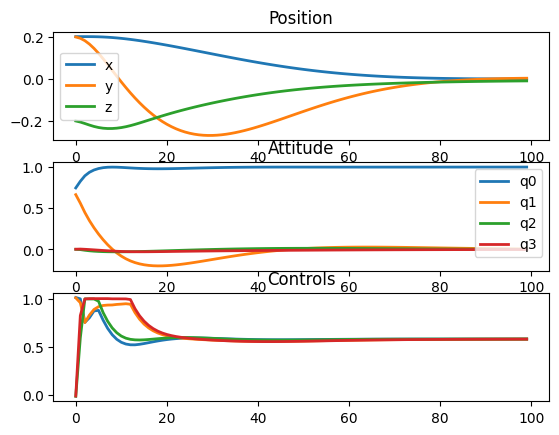

LQR - trajectory not as clean as MPC


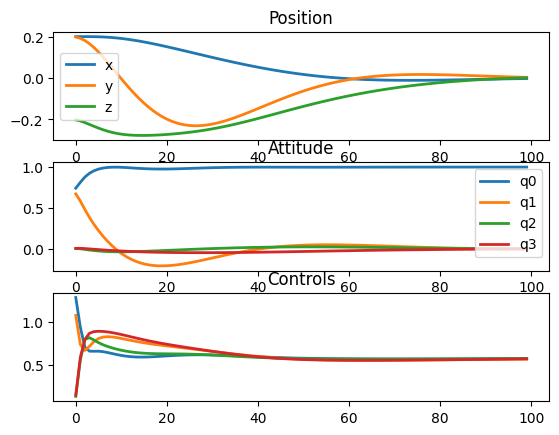

In [ ]:
def tinympc_controller(x_curr, x_nom, u_nom):
    # input is 13d state vector
    delta_x = delta_x_quat(x_curr)
    noise = np.random.normal(0, 0.01, (n,))*0
    delta_x_noise = (delta_x + noise).reshape(n).tolist()
    # print(delta_x_noise)

    # Set initial state from measurement
    x_init = np.copy(tinympc.x_prev)
    x_init[:,0] = delta_x_noise
    u_init = np.copy(tinympc.u_prev)

    # Solve the problem
    x_out, u_out, status, k = tinympc.solve_admm(x_init, u_init, x_nom, u_nom)
    print("Solved with status %d and k %d" % (status,k))

    return uhover+u_out[:,0]

x_tinympc, u_tinympc = simulate_with_controller(x0, x_nom_tinyMPC, u_nom_tinyMPC, tinympc_controller)
visualize_trajectory(x_tinympc, u_tinympc)
print("LQR - trajectory not as clean as MPC")
visualize_trajectory(x_lqr, u_lqr)